# Import

In [11]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter
from scipy.stats import zscore
from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt

import seaborn as sns 
import bk.load
import bk.compute
import bk.plot

import os

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.facecolor'] = 'grey'


In [12]:
from imports import *

# Static

In [28]:
def tsd_zscore(tsd,axis = 0):
    from scipy.stats import zscore
    t = tsd.index.values
    q = zscore(tsd.values,axis = axis)

    return nts.TsdFrame(t,q)
     
def get_extended_sleep(states, sleep_th, wake_th):

    # Return extended sleep session given state, sleep

    ext_sleep = states['NREM'].union(
        states['REM']).merge_close_intervals(wake_th, time_units='s')
    ext_sleep = ext_sleep[ext_sleep.duration(
        time_units='s') > sleep_th].reset_index(drop=True)

    return ext_sleep


def get_extended_wake(states, wake_th, sleep_th):

    # Return extended wake session given state, sleep

    ext_wake = states['wake'].merge_close_intervals(sleep_th, time_units='s')
    ext_wake = ext_wake[ext_wake.duration(
        time_units='s') > wake_th].reset_index(drop=True)

    return ext_wake


def main(base_folder, local_path, *args, **kwargs):
    state = args[0]


    bk.load.current_session_linux(base_folder,local_path)

    states = bk.load.states(True)
    extsleep = get_extended_sleep(states, 60*30, 60)
    extwake = get_extended_wake(states, 60*30, 60)

    neurons, metadata = bk.load.spikes()
    t,q = bk.compute.binSpikes(neurons,1)

    q = nts.TsdFrame(t,q.T,time_units='s')

    fr = []
    for s, e in extsleep.iloc:
        current_sleep = nts.IntervalSet(s, e)
        first = states[state].intersect(current_sleep)[0:1]
        last = states[state].intersect(current_sleep)[-1:]
        print(first)

        first_duration = int(first.duration(time_units='s'))
        last_duration = int(last.duration(time_units='s'))
        
        
        
        
        # q_z = tsd_zscore(q.restrict(current_sleep))
        # mean_z_first = np.mean(q_z.restrict(first).values,axis = 0)
        # mean_z_last = np.mean(q_z.restrict(last).values,axis = 0)
        # df = {'First':mean_z_first,'Last':mean_z_last}
        # df = pd.DataFrame(df)
        # fr.append(df)
        
        n_spikes_first = np.sum(q.restrict(current_sleep).restrict(first).values,axis = 0)
        n_spikes_last = np.sum(q.restrict(current_sleep).restrict(last).values,axis = 0)


        fr_first = n_spikes_first/first_duration
        fr_last = n_spikes_last / last_duration


        df = {'First':fr_first,'Last':fr_last}
        df = pd.DataFrame(df)
            
        fr.append(df)
    
    
    # ax = plt.subplot(211)
    # bk.plot.intervals(states['Rem'])
    # bk.plot.intervals(states['sws'],'grey')
    # plt.subplot(212, sharex = ax)
    # bk.plot.intervals(extsleep,'lightblue')
    # sns.boxplot(data = df)
    # plt.title(bk.load.session)
    # plt.draw()

    return fr,metadata


def ext_sleep_length(base_folder,local_path):
    bk.load.current_session_linux(base_folder,local_path)

    states = bk.load.states(True)
    extsleep = get_extended_sleep(states, 60*30, 60)
    
    return extsleep.duration(time_units = 's')/60


def merge(batch, name, discard):

    df = []
    metadata = []
    for i, b in batch.items():
        if (i not in discard) and b[0]:
            df.append(np.mean(b[0], axis=0))
            metadata.append(b[1])
    df = np.vstack(df)
    df = pd.DataFrame(df, columns=['First', 'Last'])

    merged = {'name': name,
              'fr': df,
              'metadata':pd.concat(metadata)}

    # merged['metadata'].Type[merged['metadata'].Region == 'CeCM'] = 'Int'
    return merged


def plot_firing_pre_post_sleep(merged,stru,type,plot_type = 'boxplot',ax = None):
    
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize = (12,4))
    
    fr = merged['fr']
    metadata = merged['metadata']
    metadata = metadata.reset_index()
    name = merged['name']
    # fr = pd.concat((fr,metadata))

    fr = fr[(metadata.Region == stru) & (metadata.Type == type)]


    plt.sca(ax)
    if plot_type == 'stripplot':
        sns.stripplot(data = np.log10(fr),size = 2, alpha = 0.5)
    elif plot_type == 'boxplot':
        sns.boxenplot(data = np.log10(fr))

    # ord = np.argsort(fr['Last'].values - fr['First'].values)
    # plt.imshow(fr.iloc[ord],aspect = 'auto',interpolation='None')
    # plt.colorbar()
    plt.ylim(-3,3)
    plt.title(f'{stru}-{type}-{name}')
    print(f'Stats on {len(fr)}')
    print(scipy.stats.wilcoxon(fr['First'],fr['Last']))
    return fr

In [15]:
batch,meta = bk.load.batch(ext_sleep_length)
ext_len = np.array(0)
for b in batch.values():
    ext_len = np.hstack((ext_len, b))
ext_len = ext_len[1:]
print(f'Mean durations of ext sleep : {np.nanmean(ext_len)}')
print(f'Std of ext sleep: {np.std(ext_len)}')
print(f'Number of ext sleep : {len(ext_len)}')


100%|██████████| 61/61 [00:03<00:00, 18.76it/s]

Batch finished in 3.3305232524871826
Some session were not processed correctly
['Rat08-20130720', 'Rat08-20130722', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat11-20150402', 'Rat11-20150403']
11.475409836065573 %
Mean durations of ext sleep : 40.429545454545455
Std of ext sleep: 12.205546462156173
Number of ext sleep : 44


NREM BLA
Stats on 1195
WilcoxonResult(statistic=231350.0, pvalue=1.047775768259438e-25)
REM BLA
Stats on 1195
WilcoxonResult(statistic=298115.0, pvalue=0.8142195406780641)


/home/billel/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/billel/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/billel/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/billel/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


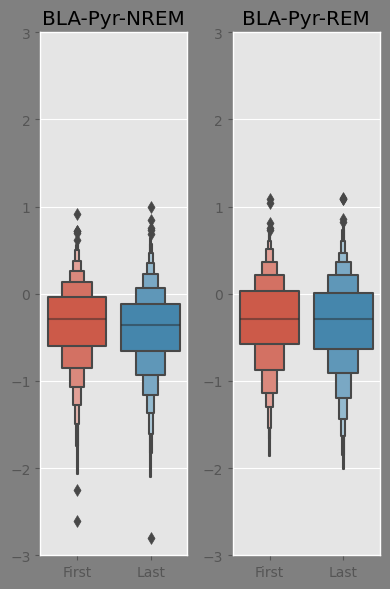

In [37]:
discard = [
    "Rat08-20130718",
    "Rat09-20140408",
    "Rat09-20140409",
    "Rat10-20140619",
    "Rat10-20140620",
    "Rat10-20140622",
]

# df = {}
# merged = {}
# for state in ['NREM','REM']:
#     args = [state]
#     df[state],meta = bk.load.batch(main,*args,verbose = False)
#     merged[state]= merge(df[state],state,discard)

stru = ['BLA']
# stru = ['CeCM']
fig,ax = plt.subplots(1,2,figsize = (4,6))
for i,s in enumerate(stru):
    print('NREM ' + s)
    plot_firing_pre_post_sleep(merged['NREM'],s,'Pyr',ax = ax[0])
    print('REM ' + s)
    plot_firing_pre_post_sleep(merged['REM'],s,'Pyr',ax = ax[1])

plt.tight_layout()

In [38]:
metadata = pd.read_csv(f'{bk.load.base}/All-Rats/States/fr_states.csv')
metadata = pd.merge(merged['NREM']['metadata'],metadata,on = ['Rat','Day','Shank','Id','Region','Type'])
fr_delta = np.array(merged['NREM']['fr'].Last  / (merged['NREM']['fr'].First))

x = metadata.SLEEP[(metadata.Region == 'BLA') & (metadata.Type == 'Pyr')].values
y = fr_delta[(metadata.Region == 'BLA') & (metadata.Type == 'Pyr')]
x = np.log10(x)

x_ = x[np.isfinite(x) & np.isfinite(y)]
y_ = y[np.isfinite(x) & np.isfinite(y)]
scipy.stats.linregress(x_,y_)

/tmp/ipykernel_12429/4030015584.py:7: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(x)


LinregressResult(slope=-0.3089444966341395, intercept=0.9360967334610399, rvalue=-0.06322793398982186, pvalue=0.029046062757926098, stderr=0.14136052403413318, intercept_stderr=0.06968350331438304)

Text(0.5, 1.0, 'Ratio FR in function of FR')

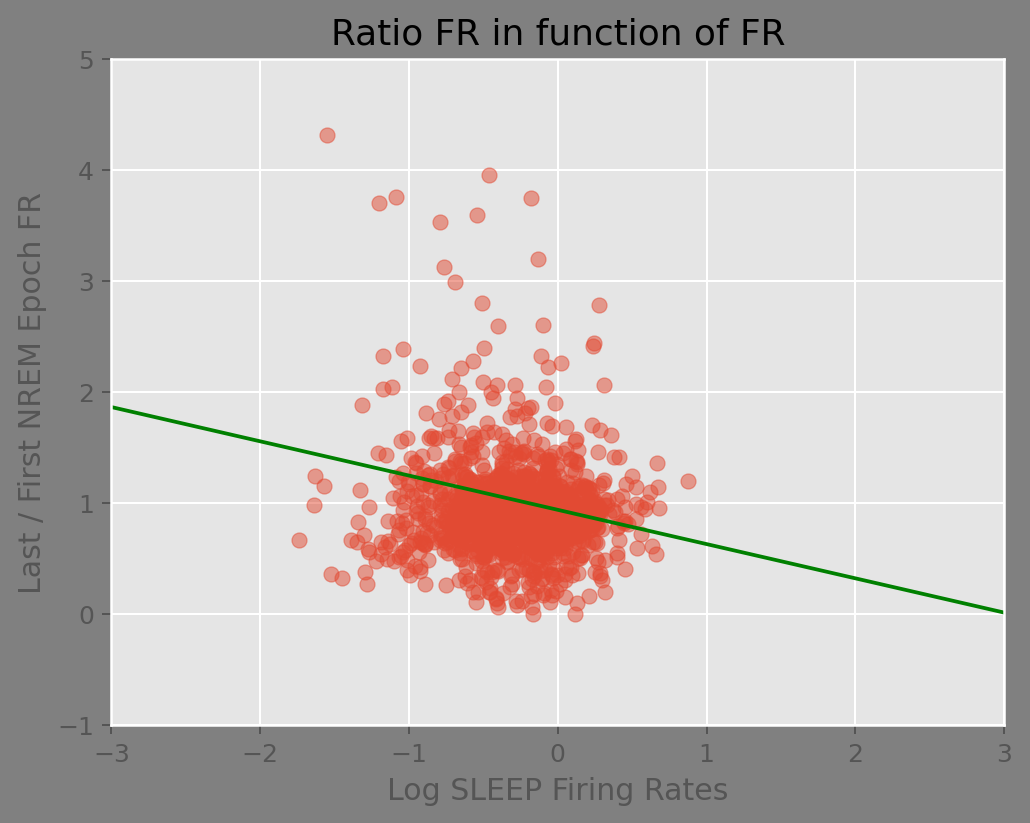

In [39]:
fig,ax = plt.subplots(1,1,dpi = 180)
lin = scipy.stats.linregress(x_,y_)
x = np.arange(-3,3,0.001)
y = x*lin.slope + lin.intercept
plt.scatter(x_,y_,alpha =.5)
plt.plot(x,y,'green')

plt.xlim(-3,3)
plt.ylim(-1,5)

plt.xlabel('Log SLEEP Firing Rates')
plt.ylabel('Last / First NREM Epoch FR')
plt.title('Ratio FR in function of FR')

In [40]:
filt_bla = (metadata.Region == 'BLA') & (metadata.Type == 'Pyr')

[]

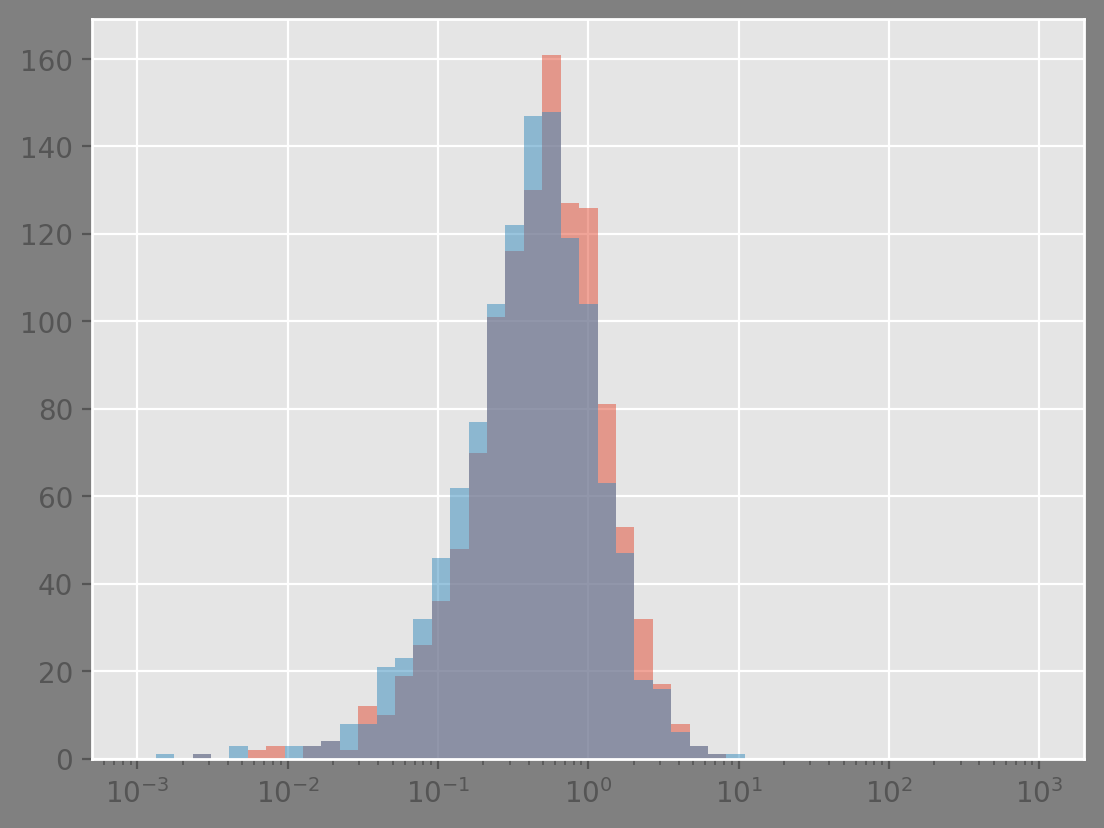

In [41]:
logbins = np.logspace(np.log10(0.001),np.log10(1000),50)
fig,ax = plt.subplots(1,1,dpi = 200)
v_f,b_f,_ = ax.hist(merged['NREM']['fr'].First[filt_bla.values],bins = logbins,alpha = 0.5)
v_l,b_l,_ = ax.hist(merged['NREM']['fr'].Last[filt_bla.values],bins = logbins,alpha = 0.5)
ax.semilogx()

NameError: name 'b_f' is not defined

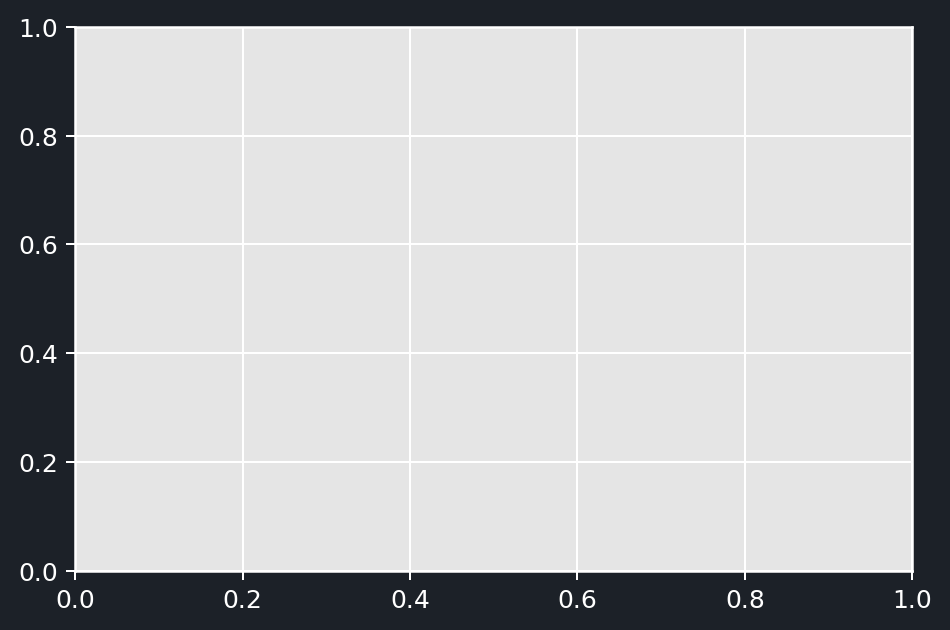

In [6]:
fig,ax = plt.subplots(dpi = 180)
plt.plot(b_f[:-1],v_f)
plt.plot(b_l[:-1],v_l)
plt.semilogx()

plt.title('Histogram of FR First vs Last Epoch of NREM Sleep')
plt.xlabel('FR (Hz)')
plt.ylabel("Occurence (count)")

plt.legend(['First','Last'])

In [10]:
merged_sws['metadata']

,Rat,Day,Shank,Id,Region,Type
0,8,1,4,2,Hpc,Pyr
1,8,1,4,3,Hpc,Pyr
2,8,1,4,4,Hpc,Int
3,8,1,4,5,Hpc,Pyr
4,8,1,4,6,Hpc,Pyr
...,...,...,...,...,...,...
72,11,20,18,14,Hpc,Pyr
73,11,20,18,15,Hpc,Int
74,11,20,20,2,Hpc,Pyr
75,11,20,20,3,Hpc,Pyr


In [6]:
args = ['Rem']
df = bk.load.batch(main,*args,verbose = False)
merged_rem = merge(df,'Rem',discard)

 33%|███▎      | 20/61 [00:24<00:43,  1.07s/it]

Loading Data from Rat09-20140401
Rat : 9 on day : 8
Working with session Rat09-20140401 @ /home/billel/Data/GG-Dataset/Rat09/Rat09-20140401
Data already saved in Numpy format, loading them from here:
Rat09-20140401-neurons.npy


In [ ]:
args = ['wake']
df = bk.load.batch(main,*args,verbose = False)
merged_wake = merge(df,'wake',discard)

100%|██████████| 61/61 [02:39<00:00,  2.62s/it]

Batch finished in 159.5758593082428
Some session were not processed correctly
['Rat08-20130708', 'Rat08-20130709', 'Rat08-20130710', 'Rat08-20130712', 'Rat08-20130713', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140325', 'Rat09-20140326', 'Rat09-20140331', 'Rat09-20140401', 'Rat09-20140402', 'Rat09-20140405', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140624', 'Rat10-20140626', 'Rat10-20140627', 'Rat10-20140629', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150315', 'Rat11-20150323', 'Rat11-20150327', 'Rat11-20150330', 'Rat11-20150331', 'Rat11-20150401']
54.09836065573771 %


In [ ]:
%matplotlib qt
plot_firing_pre_post_sleep(merged_sws,'BLA','Pyr')
plot_firing_pre_post_sleep(merged_rem,'BLA','Pyr')

NameError: name 'plot_firing_pre_post_sleep' is not defined

# Across Time

Here I will try to reproduce Miyawaki2016 / Torrado2021 analysis in which they show the average FR across sleep

In [3]:
from imports import *

In [4]:
def debug(base_folder,local_path,*args,**kwargs):
    bk.load.current_session_linux(base_folder,local_path)
    states = bk.load.states()

    extended_wake = get_extended(states, 'wake', 60, 60*30)
    # extended_wake = get_extended(states, 'wake', 60*30, 60)

    fig,ax = plt.subplots(1,1)
    bk.plot.intervals(extended_wake,'red',ax = ax)
    bk.plot.intervals(states['sws'],'grey',ax=ax)
    bk.plot.intervals(states['Rem'],'orange',ax=ax)

In [3]:
bk.load.batch(debug)

100%|██████████| 61/61 [00:01<00:00, 49.92it/s]

Batch finished in 1.2312822341918945
Some session were not processed correctly
['Rat08-20130708', 'Rat08-20130709', 'Rat08-20130710', 'Rat08-20130711', 'Rat08-20130712', 'Rat08-20130713', 'Rat08-20130715', 'Rat08-20130716', 'Rat08-20130717', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140325', 'Rat09-20140326', 'Rat09-20140327', 'Rat09-20140328', 'Rat09-20140329', 'Rat09-20140331', 'Rat09-20140401', 'Rat09-20140402', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140622', 'Rat10-20140624', 'Rat10-20140626', 'Rat10-20140627', 'Rat10-20140628', 'Rat10-20140629', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150321', 'R

({},
 Empty DataFrame
 Columns: []
 Index: [])

In [60]:
def compute_eib(neurons, metadata, stru, start=0, stop=None, binSize=0.025, nbins=None,as_tsd = False):
    activity = bk.compute.binSpikes(neurons, start=start, stop=stop,binSize = binSize, nbins=nbins, as_Tsd=True)
    masks = {}
    masks['STRU_PYR'] = (metadata.Region == stru) & (metadata.Type == 'Pyr')
    masks['STRU_INT'] = (metadata.Region == stru) & (metadata.Type == 'Int')
    e_spikes = np.sum(activity.loc[:, masks['STRU_PYR']].values, 1)
    i_spikes = np.sum(activity.loc[:, masks['STRU_INT']].values, 1)
    eib = e_spikes / (e_spikes + i_spikes)
    # eib[~np.isfinite(eib)] = np.nan
    
    if as_tsd: eib = nts.Tsd(activity.times(),eib)
    return eib

def tsd_zscore(tsd, axis=0):
    from scipy.stats import zscore
    t = tsd.index.values
    q = zscore(tsd.values, axis=axis)

    return nts.TsdFrame(t, q)


def get_extended(states, state='sleep', sleep_th=60*30, wake_th=60):
    # Return extended sleep session given state, sleep
    if state.lower() == 'sleep':
        extended = states['NREM'].union(
            states['REM']).merge_close_intervals(wake_th, time_units='s')
        extended = extended[extended.duration(
            time_units='s') > sleep_th].reset_index(drop=True)

    elif state.lower() == 'wake':
        extended = states['WAKE_HOMECAGE'].merge_close_intervals(
            sleep_th, time_units='s')
        extended = extended[extended.duration(
            time_units='s') > wake_th].reset_index(drop=True)
    return extended


def main(base_folder, local_path, *args, **kwargs):

    binSize = kwargs['binSize']

    bk.load.current_session_linux(local_path=local_path)
    states = bk.load.states(True)
    neurons, metadata = bk.load.spikes()

    z_fr_across_extended = {}

    extended_sleep = get_extended(states, 'sleep', 60*30, 60)

    for state in ['NREM', 'REM']:
        ext_sleep_b = []
        for s, e in extended_sleep.as_units('s').iloc:
            t, b = bk.compute.binSpikes(neurons, binSize, s, e)
            b = nts.TsdFrame(t, b.T, 's').restrict(states[state])
            b = tsd_zscore(b)
            b.index = np.round(b.index - s*1_000_000)
            ext_sleep_b.append(b)

        z_fr_across_extended.update({state: ext_sleep_b})

    extended_wake = get_extended(states, 'wake', 60, 60*30) 
    ext_wake_b = []
    for s, e in extended_wake.as_units('s').iloc:
        t, b = bk.compute.binSpikes(neurons, binSize, s, e)
        b = nts.TsdFrame(t, b.T, 's')
        b = tsd_zscore(b)
        b.index = np.round(b.index - s*1_000_000)
        ext_wake_b.append(b)
    z_fr_across_extended.update({'WAKE_HOMECAGE': ext_wake_b})

    return z_fr_across_extended, metadata



def main_eib(base_folder, local_path, *args, **kwargs):

    binSize = kwargs['binSize']
    stru = kwargs['stru']
    bk.load.current_session_linux(local_path=local_path)
    states = bk.load.states(True)
    neurons, metadata = bk.load.spikes()
        
    if np.sum((metadata.Region == stru) & (metadata.Type == 'Int')) <3:
        raise IndexError('Less than 5 interneurons')
    z_fr_across_extended = {}

    extended_sleep = get_extended(states, 'sleep', 60*30, 60)

    for state in ['NREM', 'REM']:
        ext_sleep_b = []
        for s, e in extended_sleep.as_units('s').iloc:
            b = compute_eib(neurons,metadata,stru,s,e,binSize=binSize,as_tsd=True).restrict(states[state])
            b = tsd_zscore(b)
            b.index = np.round(b.index - s*1_000_000)
            ext_sleep_b.append(b)

        z_fr_across_extended.update({state: ext_sleep_b})

    extended_wake = get_extended(states, 'wake', 60, 60*30) 
    ext_wake_b = []
    for s, e in extended_wake.as_units('s').iloc:
        b = compute_eib(neurons,metadata,stru,s,e,binSize=5,as_tsd=True)
        b = tsd_zscore(b)
        b.index = np.round(b.index - s*1_000_000)
        ext_wake_b.append(b)
    z_fr_across_extended.update({'WAKE_HOMECAGE': ext_wake_b})

    return z_fr_across_extended, metadata


def merge_eib(batch,metadata):
    merged_all = {}
    metadata_all = {}

    for state in ['NREM', 'REM', 'WAKE_HOMECAGE']:
        merged = []
        metadata_ = []
        for i, (ext, metadata) in batch.items():
            for j in ext[state]:
                merged.append(j)
                metadata_.append(metadata)
        merged = pd.concat(merged, axis=1)
        merged.columns = range(merged.columns.size)
        merged_all.update({state: merged})
        metadata_all[state] = metadata_
    return merged_all,metadata_all
   
def merge(batch,metadata, stru='BLA', type = 'Pyr'):
    merged_all = {}
    metadata_all = {}
    for state in ['NREM', 'REM', 'WAKE_HOMECAGE']:
        merged = []
        metadata_ = []
        for i, (ext, metadata) in batch.items():
            if np.any((metadata.Region == stru) & (metadata.Type == type)):
                for j in ext[state]:
                    if np.any(np.isfinite(j.values[:, (metadata.Region == stru) & (metadata.Type == type)])):
                        # add -j.index.values[-1] if we want to plot by the end of extsleep
                        merged.append(nts.TsdFrame(j.index.values, np.nanmean(
                            j.values[:, (metadata.Region == stru) & (metadata.Type == type)], 1)))
                        metadata_.append(metadata)
                    # merged.append(nts.TsdFrame(j.index.values,j.values))
        
        merged = pd.concat(merged, axis=1)
        merged.columns = range(merged.columns.size)
        merged_all.update({state: merged})
        metadata_all[state] = metadata_
    return merged_all,metadata_all


def compute_linreg(merged, time_units='s'):
    t = []
    v = []
    for i in merged:
        t.append(merged.as_units(time_units).index.values)
        v.append(merged[i].values)

    t = np.array(t)
    v = np.array(v)

    t_clean = t[np.isfinite(v)]
    v_clean = v[np.isfinite(v)]
    reg = scipy.stats.linregress(t_clean, v_clean)
    print(reg)
    return reg


def plot_ext_sleep_fr(merged, reg, color='grey', s=5, ax=None):
    
    ext_sess = merged.shape[1]
    
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    
    plt.sca(ax)
    for i in merged:
        plt.scatter(merged.as_units('s').index.values,
                    merged[i].values, facecolor=color, s=s, alpha=0.5)
    x = np.arange(0, np.max(merged.as_units('s').index.values))
    y = x * reg.slope + reg.intercept


    

    ax.plot(x, y, 'red')
    ax.set_title(f'{stru} - {state} - {ext_sess}')
    ax.set_ylabel('Firing Rates (Zscore)')
    ax.set_xlabel('Time From Extended Sleep (s)')
    ax.set_ylim(-2, 2)
    # ax.set_xlim(0, x[-1])


    ax.text(50,-1.5,f'pValue : {reg.pvalue:.2f} \nrValue : {reg.rvalue:.2f}')
    

    plt.tight_layout()


In [61]:
def plot_averaged_activity_across_sleep(merged):
    t = merged.times('s')
    x = np.nanmean(merged.values,1)
    e = scipy.stats.sem(merged.values,1,nan_policy='omit')
    plt.errorbar(t,x,e, linestyle='None', marker='.')

In [29]:
binSize = 60
kwargs = {
    'binSize':binSize,
    'stru':'BLA'
}
# t,b,s,e = main('/mnt/electrophy/Gabrielle/GG-Dataset-Light/','Rat08/Rat08-20130711',**kwargs)
# t,b,s,e = main('/mnt/electrophy/Gabrielle/GG-Dataset-Light/','Rat11/Rat11-20150330',**kwargs)

100%|██████████| 61/61 [01:02<00:00,  1.03s/it]

Batch finished in 62.84788799285889
Some session were not processed correctly
['Rat08-20130708', 'Rat08-20130715', 'Rat08-20130716', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140624', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150331', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
57.377049180327866 %



/home/billel/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


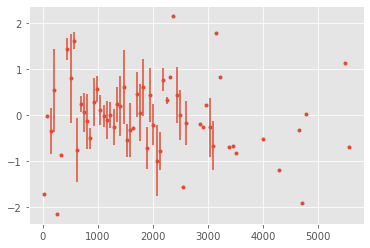

In [62]:
binSize = 60
kwargs = {
    'binSize':binSize,
    'stru':'BLA'
}
batch,metadata = bk.load.batch(main_eib, verbose=False, **kwargs) 

stru = 'BLA'
state = 'NREM'
color = 'grey'
merged,meta = merge_eib(batch,metadata)
# plt.subplots(dpi = 200)
plot_averaged_activity_across_sleep(merged['REM'])
# plt.title('NREM')
# plt.ylim(-1,1)


In [48]:
merged['NREM'].as_units('s')

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Time (s),,,,,,,,,,,,,,,,,,,,,
30.0,0.848766,-0.097035,-0.739120,-0.223365,-0.071774,0.350379,1.083410,-2.213083,-1.763398,0.201547,...,-1.845474,-0.882646,-0.066251,-1.567170,-0.421033,1.030501,-0.607756,-0.251862,0.102680,0.477634
90.0,0.869810,0.466490,0.052064,-0.934031,0.607134,0.591575,-1.772343,0.239646,-0.046661,0.862121,...,-1.941309,-0.737925,-0.764513,-1.472970,0.162915,1.352815,0.600977,0.504015,-0.951498,0.670500
150.0,0.832326,0.241588,1.086282,-1.764173,0.643584,0.539967,0.845681,-0.943118,-1.466529,0.838694,...,-2.415107,-0.721267,-0.822406,-0.749088,0.009887,-0.258366,-1.532886,0.581668,0.070622,0.340144
210.0,0.231633,2.339164,2.284037,0.082808,0.631363,-0.163987,0.016165,-0.259086,-0.090818,0.942621,...,-1.800626,-0.419454,-1.257558,-0.232135,0.264582,-0.384436,-1.091487,0.444747,-0.414892,0.369499
270.0,-0.671067,-3.480717,0.369832,-1.180605,0.344471,0.127598,0.603788,-0.279327,0.853951,1.433036,...,-1.644591,-1.557264,-1.155988,0.066327,0.252953,1.453858,-1.402503,0.749585,-2.194901,1.550763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5430.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.473297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5490.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.516400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.948764,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


BLA NREM
LinregressResult(slope=-5.42035790418462e-05, intercept=0.07865501051890612, rvalue=-0.05997076144458611, pvalue=0.10238433786165538, stderr=3.3143389494399425e-05, intercept_stderr=0.060479371278915)
BLA REM
LinregressResult(slope=-8.68608448727121e-05, intercept=0.14440890336179776, rvalue=-0.09002826677751789, pvalue=0.2606152203023298, stderr=7.693353567980667e-05, intercept_stderr=0.15072440376132257)
BLA WAKE_HOMECAGE
LinregressResult(slope=-1.027971264632856e-05, intercept=0.015752076556117316, rvalue=-0.01136015324869502, pvalue=0.05293994095579813, stderr=5.3111690726403075e-06, intercept_stderr=0.010034230066442574)


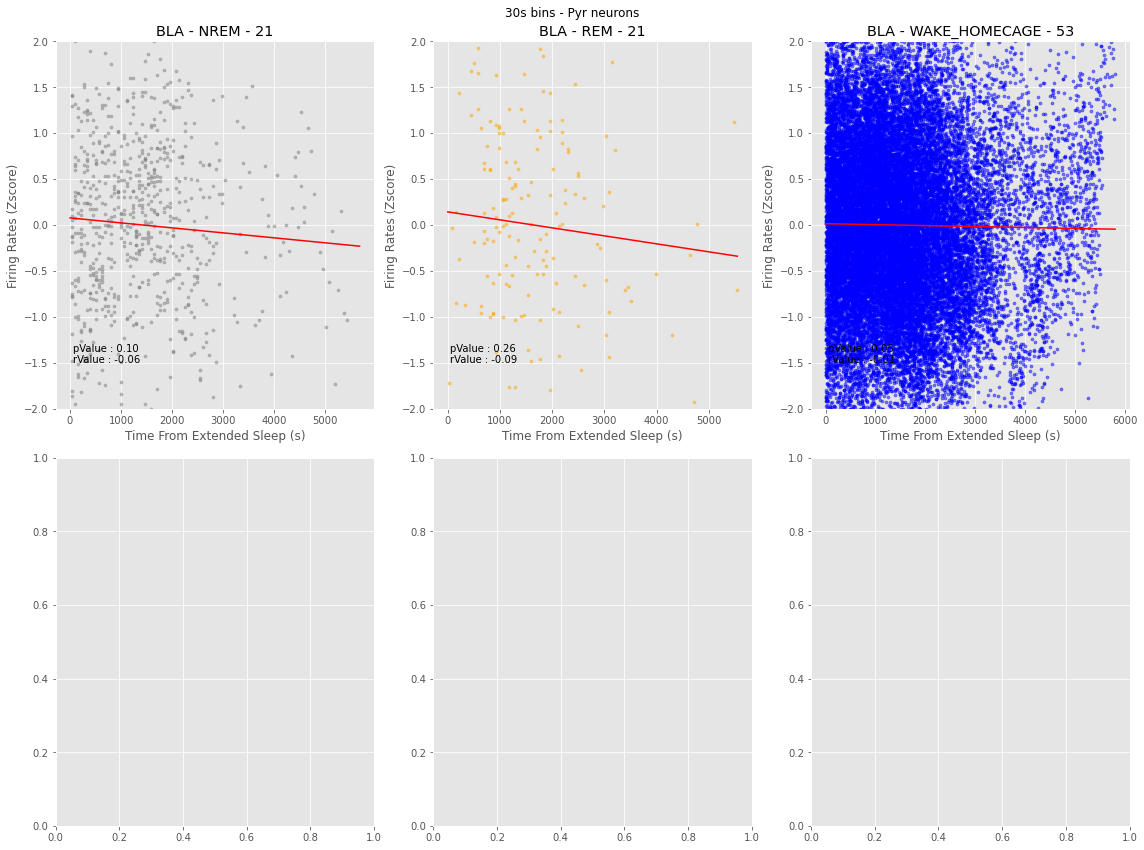

In [63]:
fig, ax = plt.subplots(2, 3, figsize=(16, 12))
# structures = ['Hpc', 'BLA', 'CeCM', 'Pir','DEn','LaDL','CPu']
structures = ['BLA']
states = ['NREM', 'REM','WAKE_HOMECAGE']
colors = ['grey', 'orange','blue']
for j, (state, c) in enumerate(zip(states, colors)):
        print(stru, state)
        merged,m = merge_eib(batch,meta)
        reg = compute_linreg(merged[state])
        plot_ext_sleep_fr(merged[state], reg, c, 10, ax[i, j])
plt.suptitle('30s bins - Pyr neurons')
plt.tight_layout()

BLA NREM
LinregressResult(slope=-6.654345515241279e-05, intercept=0.09988800925679026, rvalue=-0.07364218912933469, pvalue=0.024561236944262266, stderr=2.9549922829440507e-05, intercept_stderr=0.05510899015603335)
BLA REM
LinregressResult(slope=-6.654345515241279e-05, intercept=0.09988800925679026, rvalue=-0.07364218912933469, pvalue=0.024561236944262266, stderr=2.9549922829440507e-05, intercept_stderr=0.05510899015603335)
BLA WAKE_HOMECAGE


ValueError: Inputs must not be empty.

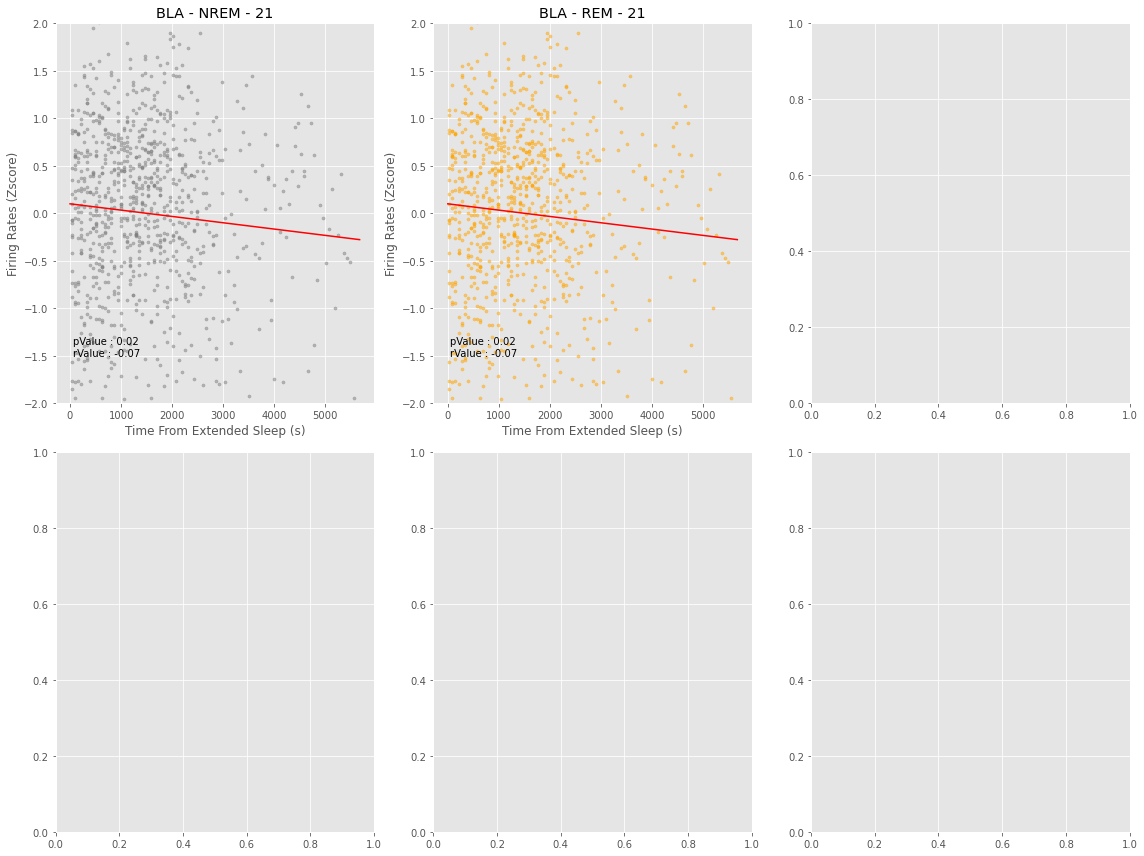

In [58]:
fig, ax = plt.subplots(2, 3, figsize=(16, 12))
# structures = ['Hpc', 'BLA', 'CeCM', 'Pir','DEn','LaDL','CPu']
structures = ['BLA']
states = ['NREM', 'REM','WAKE_HOMECAGE']
colors = ['grey', 'orange','blue']

for i, stru in enumerate(structures):
    for j, (state, c) in enumerate(zip(states, colors)):
        print(stru, state)
        merged,m = merge_eib(batch,meta)
        reg = compute_linreg(merged[state])
        plot_ext_sleep_fr(merged[state], reg, c, 10, ax[i, j])
plt.suptitle('30s bins - Pyr neurons')
plt.tight_layout()
# plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures_Gabrielle/Firing_Across_Sleep/firing_across_sleep.svg')

In [21]:
meta['WAKE_HOMECAGE'][64]
bk.load.current_session_linux(byrat=11,byday= 18)

Rat : 11 on day : 18
Working with session Rat11-20150330 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat11/Rat11-20150330


True

In [8]:
q = merged['WAKE_HOMECAGE'].index.values

In [9]:
q = merged['WAKE_HOMECAGE']
q = pd.DataFrame(q)

In [26]:
a = 203.9
b = 263.9

(a*1_000_000 + b*1_000_000) / 1_000_000

467.8

In [27]:
a+b

467.79999999999995

In [16]:
29999999/1_000_000

29.999999

/home/billel/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


(-1.0, 1.0)

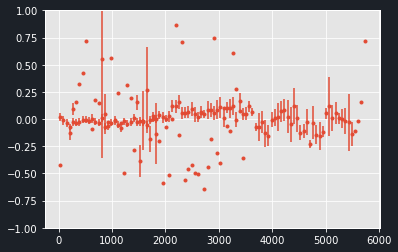

Hpc NREM


TypeError: tuple indices must be integers or slices, not str

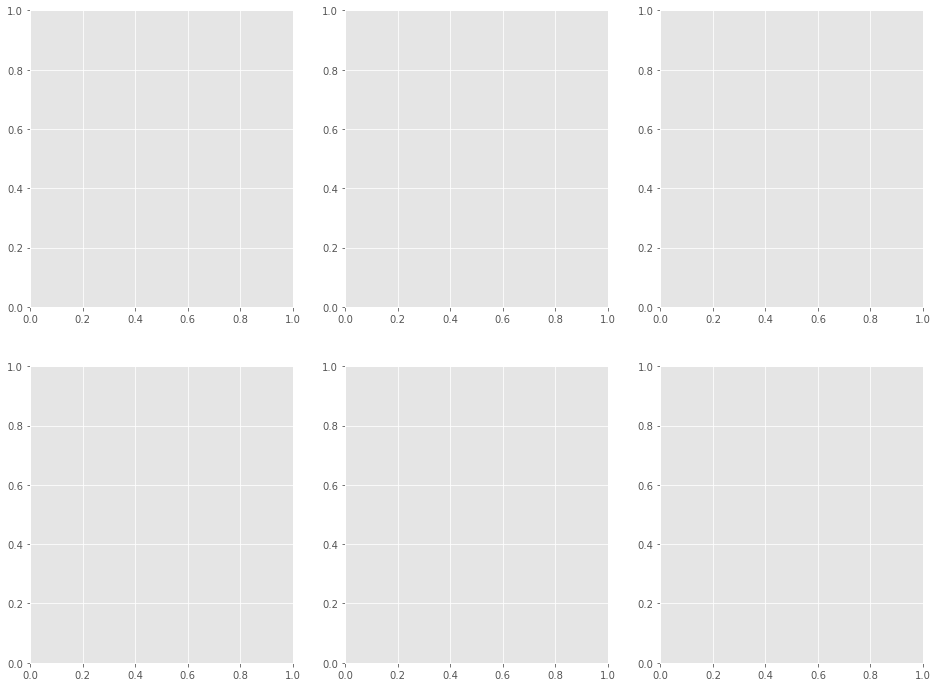

In [38]:
fig, ax = plt.subplots(2, 3, figsize=(16, 12))
# structures = ['Hpc', 'BLA', 'CeCM', 'Pir','DEn','LaDL','CPu']
structures = ['Hpc','BLA']
states = ['NREM', 'REM','WAKE_HOMECAGE']
colors = ['grey', 'orange','blue']


for i, stru in enumerate(structures):
    for j, (state, c) in enumerate(zip(states, colors)):
        print(stru, state)
        merged = merge(batch[0], stru,'Pyr')
        reg = compute_linreg(merged[state])
        plot_ext_sleep_fr(merged[state], reg, c, 10, ax[i, j])
plt.suptitle('30s bins - Pyr neurons')
plt.tight_layout()
# plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures_Gabrielle/Firing_Across_Sleep/firing_across_sleep.svg')

/tmp/ipykernel_192836/2469364104.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


IndexError: index 32 is out of bounds for axis 1 with size 32

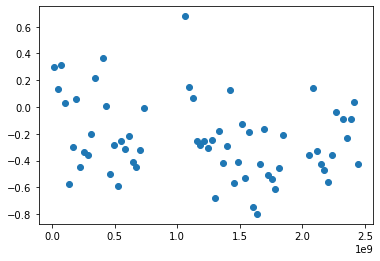

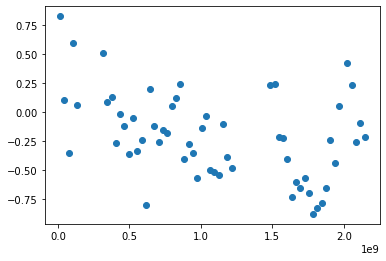

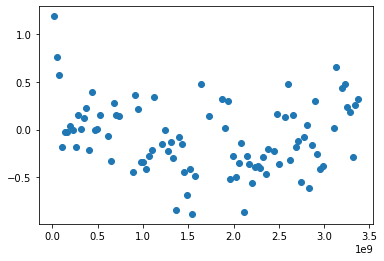

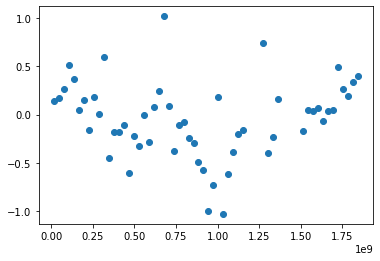

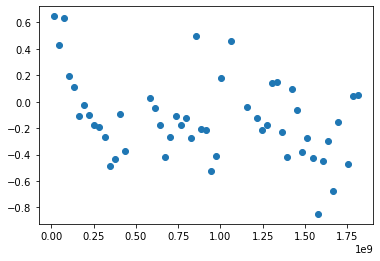

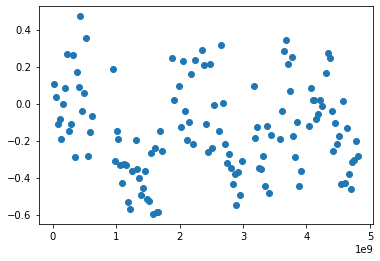

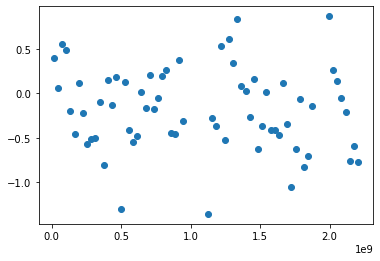

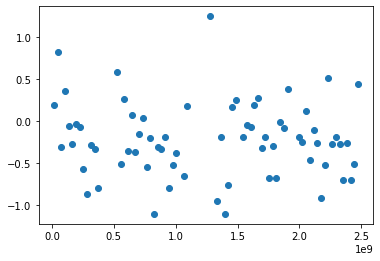

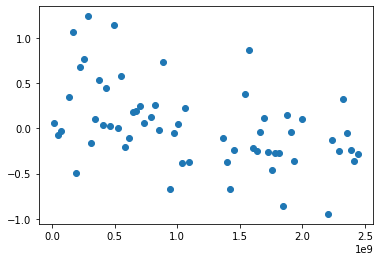

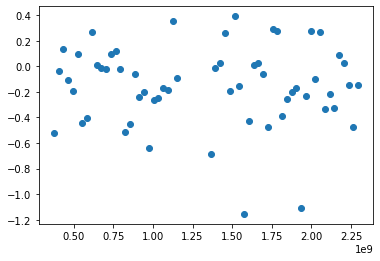

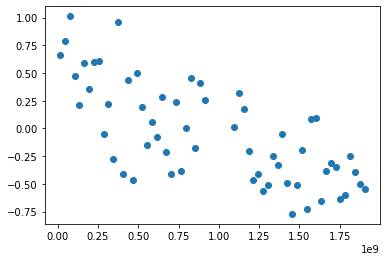

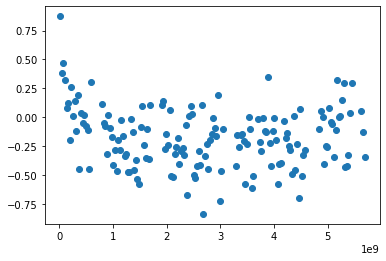

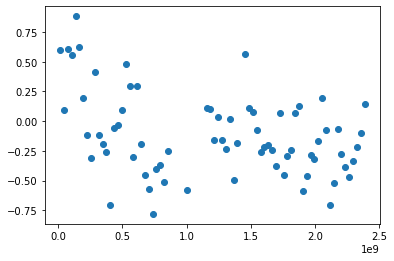

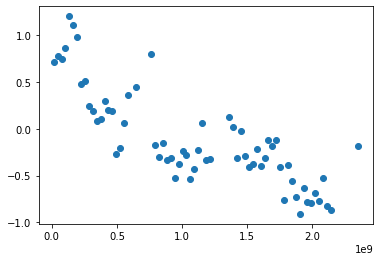

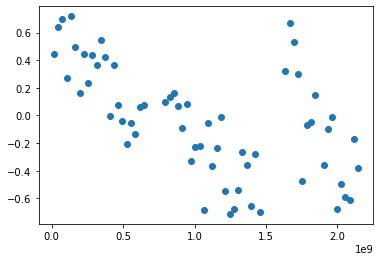

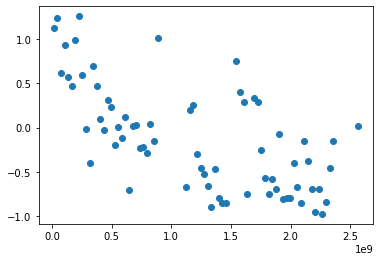

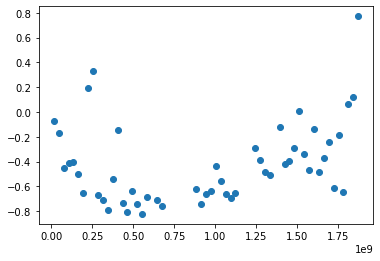

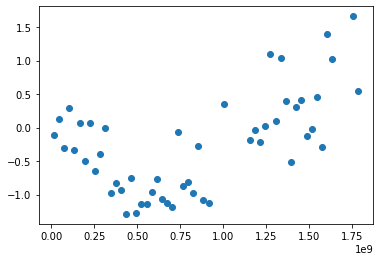

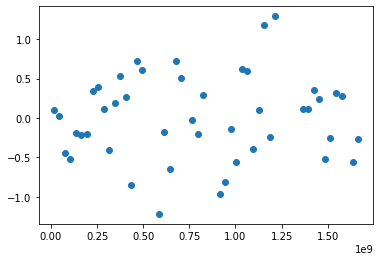

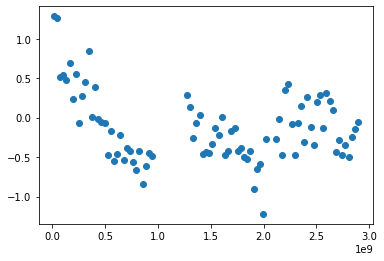

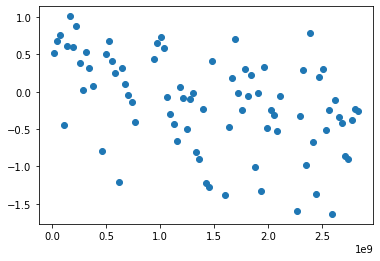

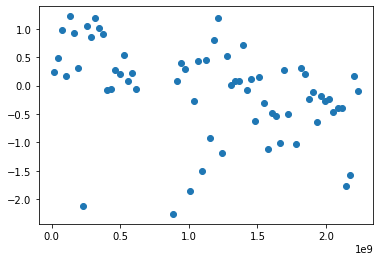

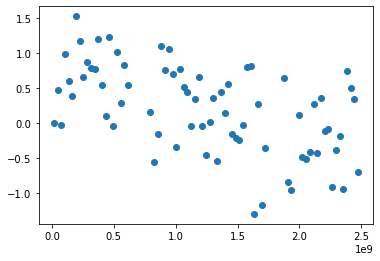

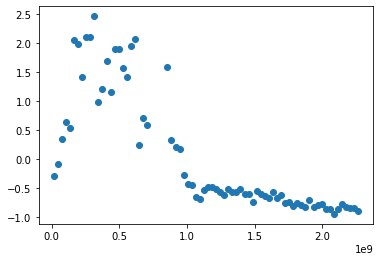

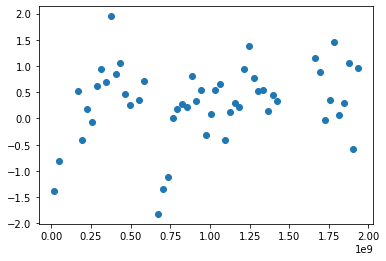

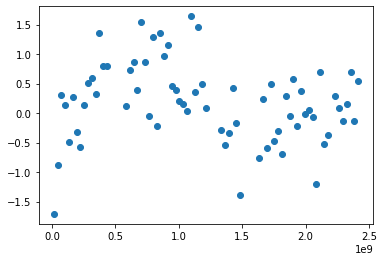

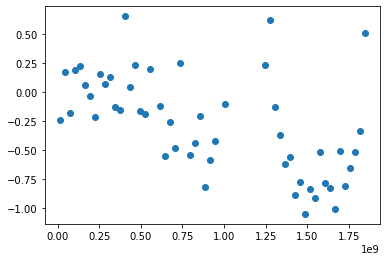

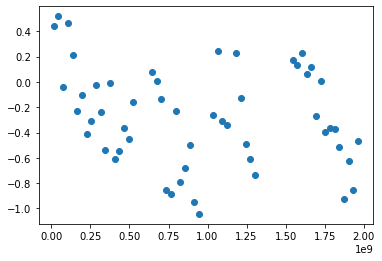

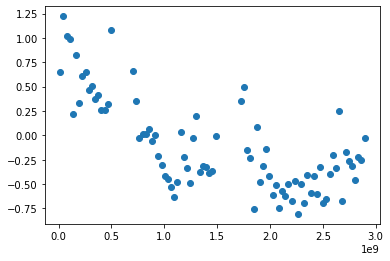

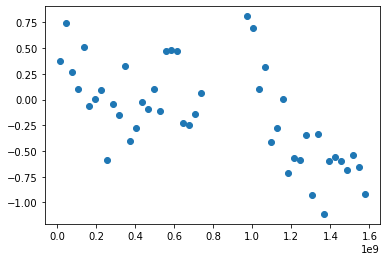

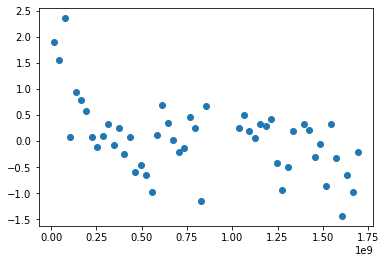

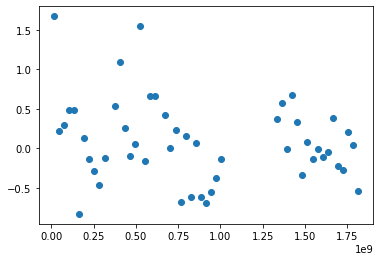

<Figure size 432x288 with 0 Axes>

In [71]:
merged = merge(batch[0], 'BLA','Int')
for i in range(35):
    plt.figure()
    plt.scatter(merged['sws'].index.values,merged['sws'].values[:,i])

In [2]:
import scipy.stats
scipy.stats.mannwhitneyu()

AttributeError: module 'scipy.stats' has no attribute 'wilcoxson'